In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import phik
import math
from phik import resources, report, phik_matrix

In [82]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [83]:

train = pd.read_csv('data/train.csv')

train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [84]:
train.id.nunique() == train.shape[0]

True

In [85]:
train.set_index('id', inplace=True)

Смотрим распределение таргета

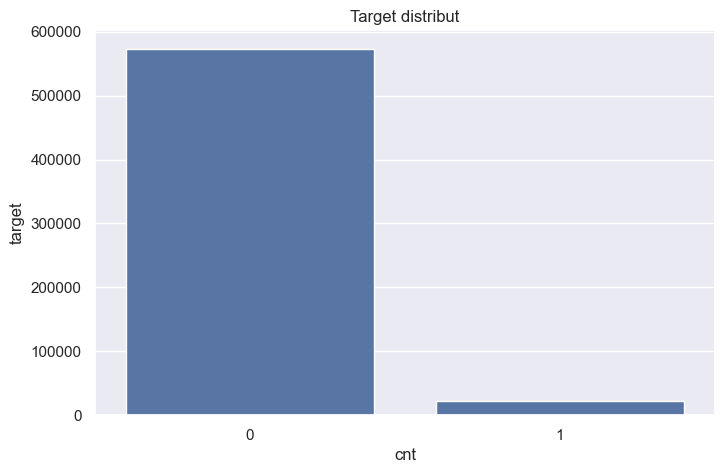

In [86]:
sns.set()
plt.figure(figsize=(8, 5))
sns.countplot(data=train, x='target')
plt.title('Target distribut')
plt.xlabel('cnt')
plt.ylabel('target')
plt.show()

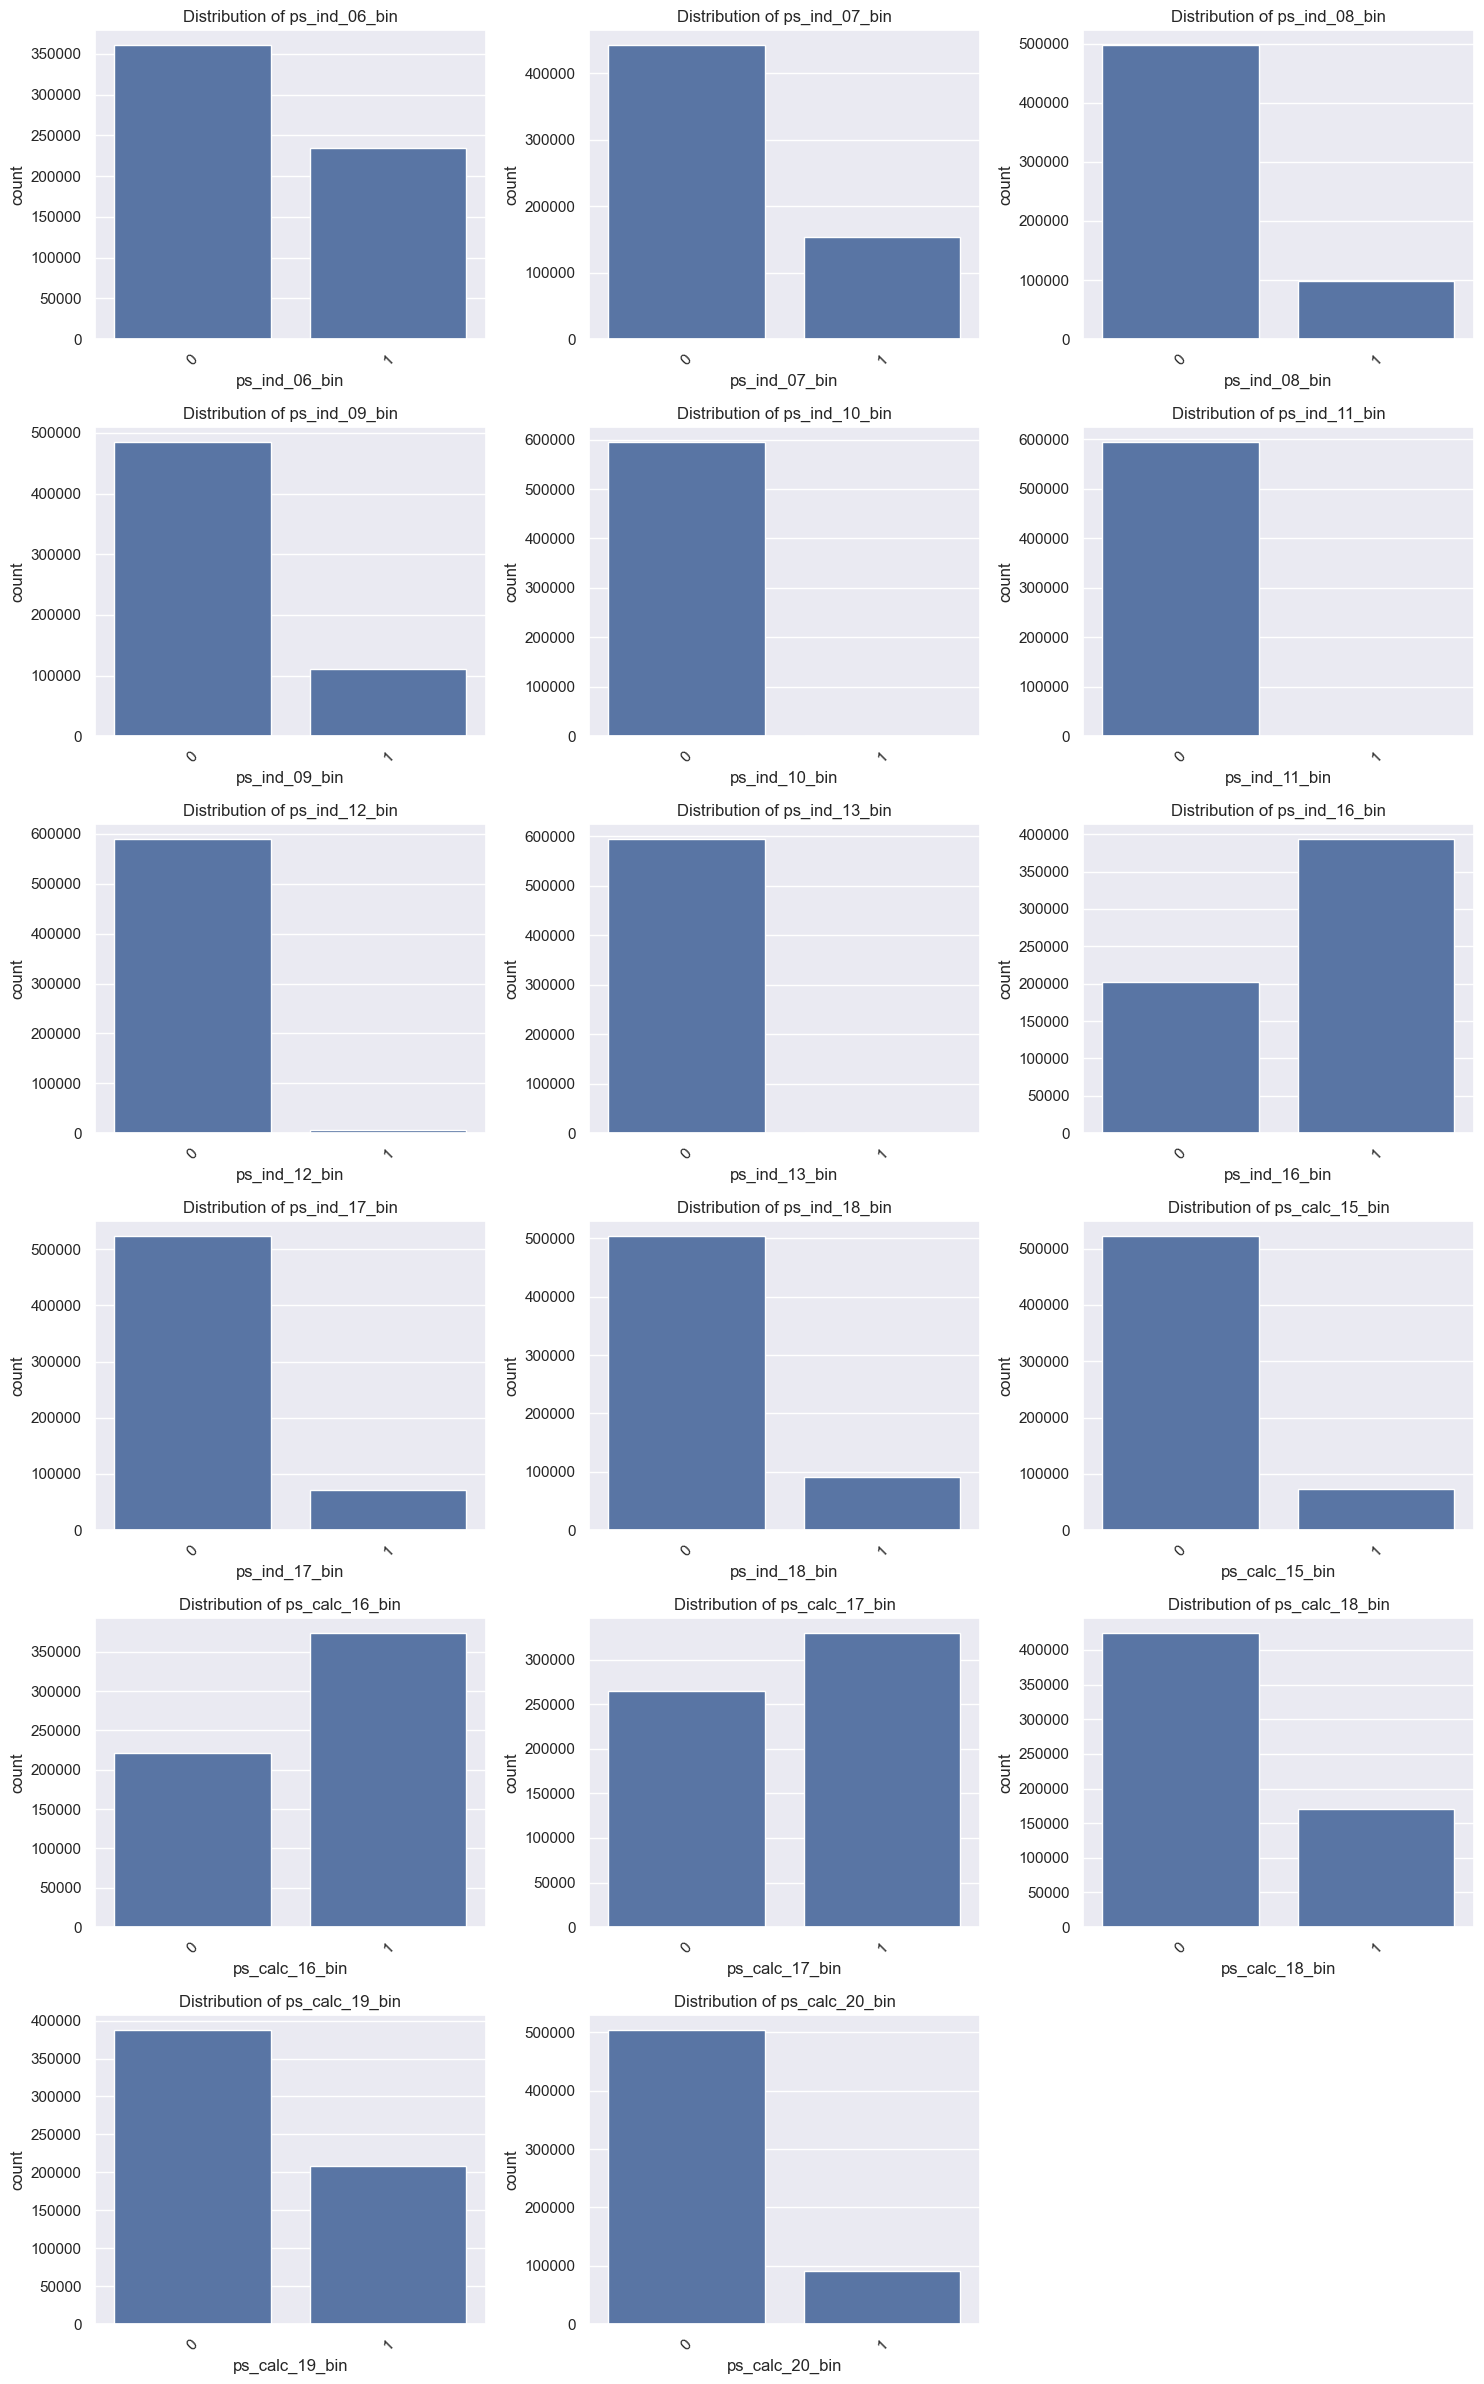

In [87]:

bin_features = [x for x in list(train.columns) if 'bin' in x]

def cat_plots(data, features, cols=3, hue=None):
    n_features = len(features)
    rows = math.ceil(n_features / cols)
    
    plt.figure(figsize=(cols * 5, rows * 4))
    
    for i, col in enumerate(features):
        plt.subplot(rows, cols, i + 1)
        sns.countplot(data=data, x=col, hue=hue) 
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        
    plt.tight_layout()
    plt.show()

cat_plots(train, bin_features)

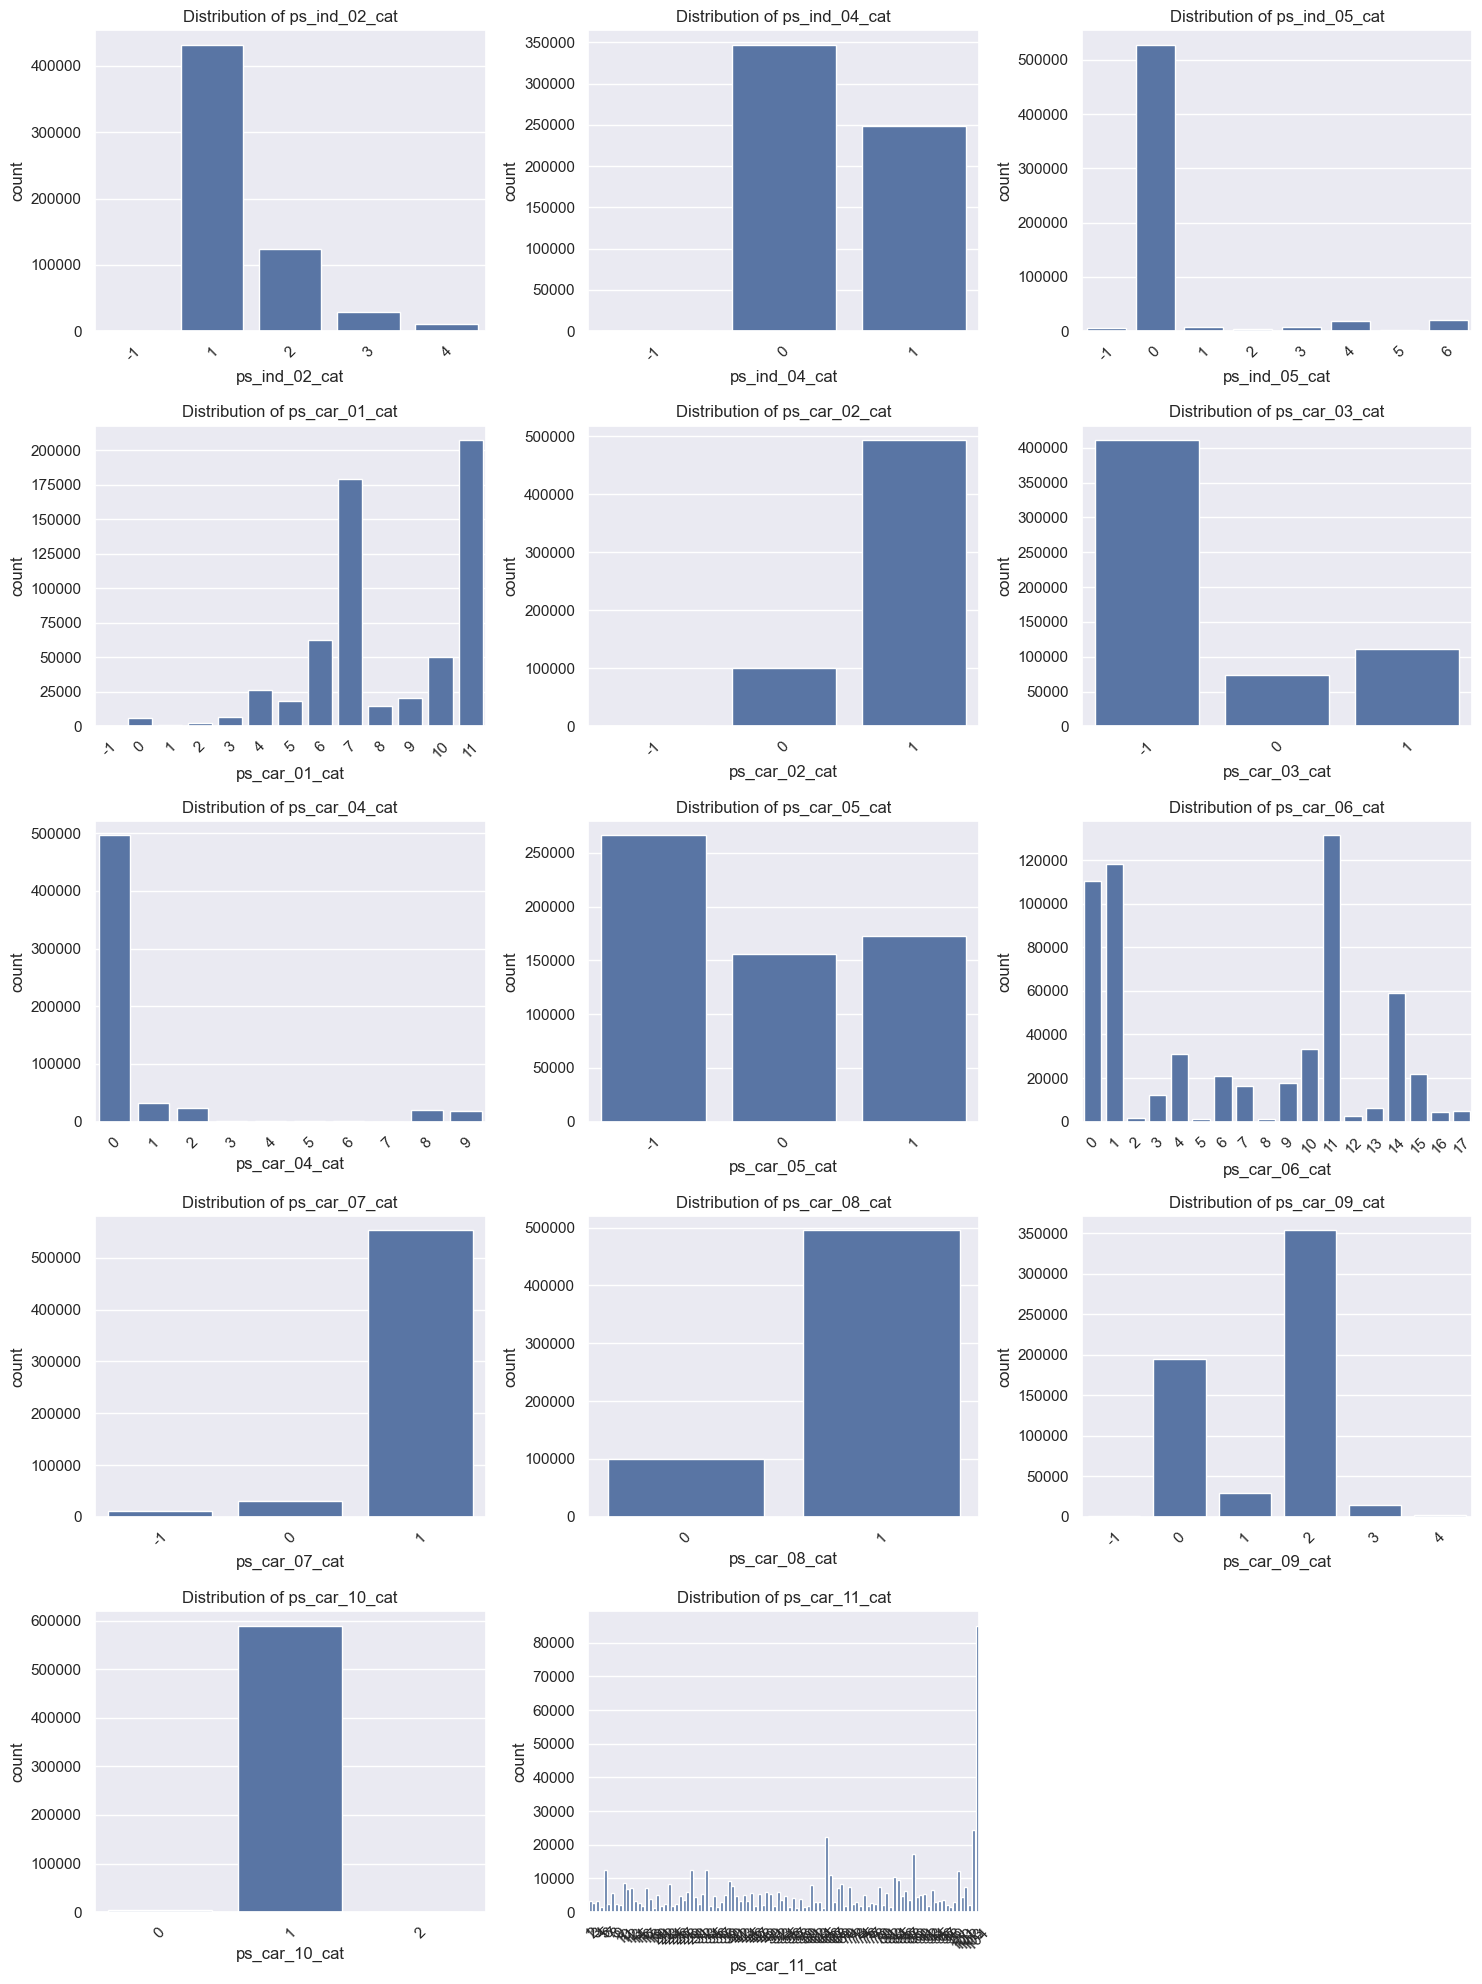

In [88]:
cat_features = [x for x in list(train.columns) if 'cat' in x]
cat_plots(train, cat_features)

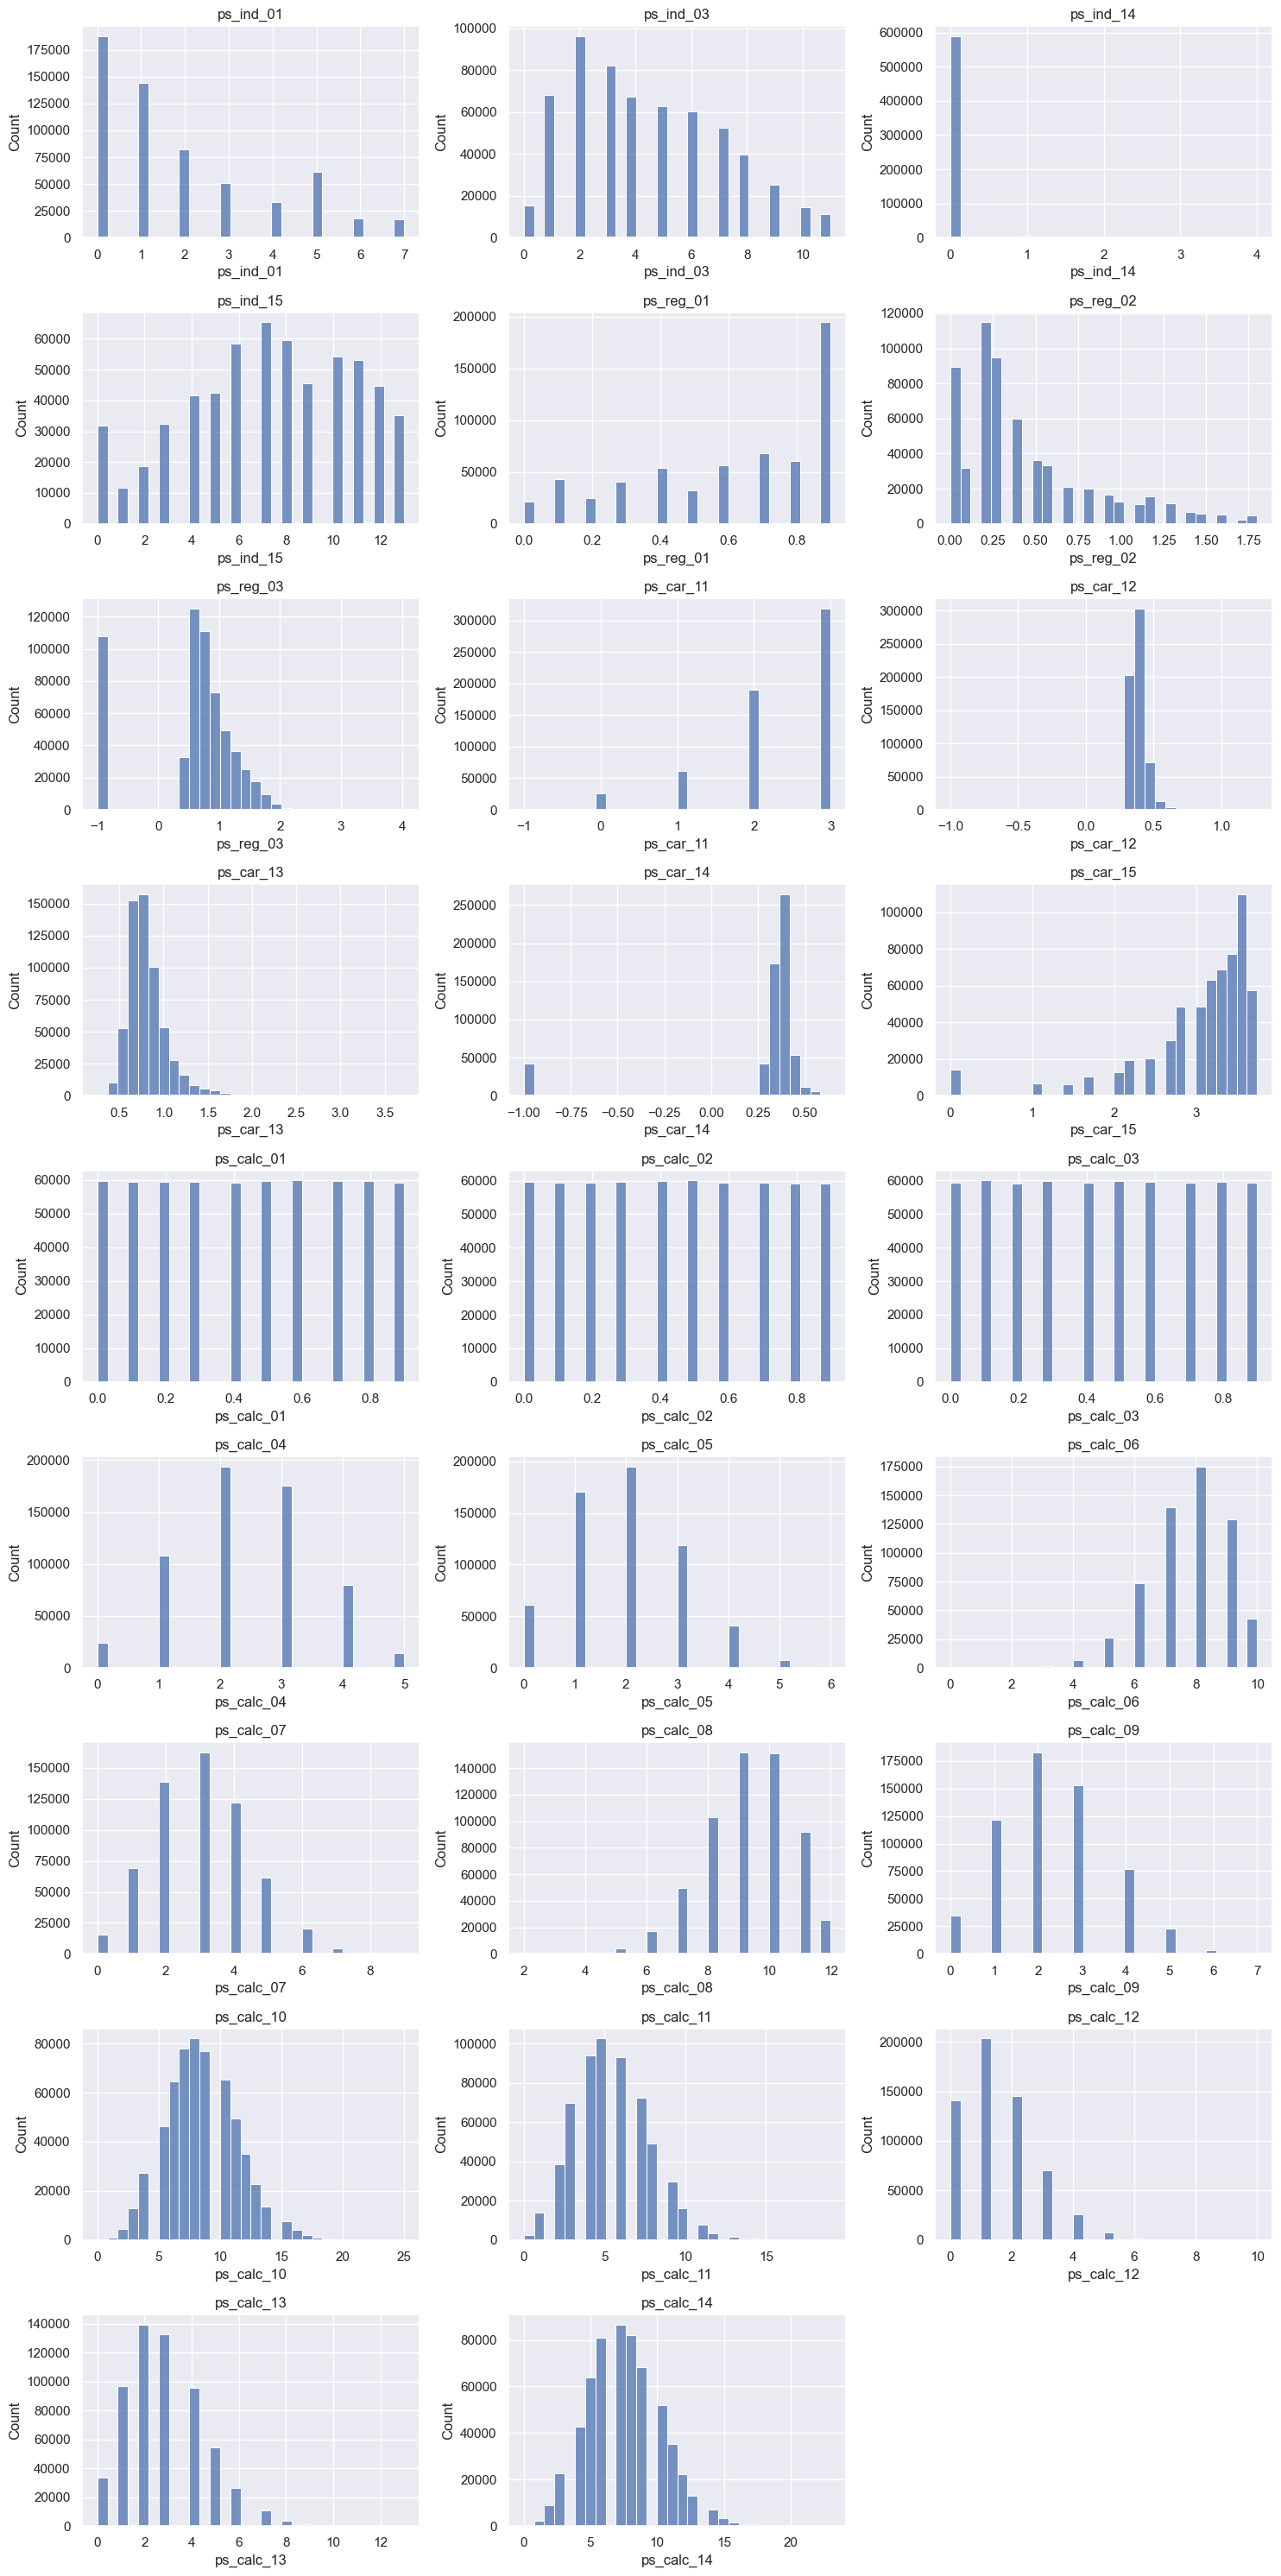

In [89]:
num_features = [x for x in list(train.columns) if 'cat' not in x and 'bin' not in x and x not in ['target']]
num_features
plt.figure(figsize=(15, 30))

for i, col in enumerate(num_features):
    plt.subplot(9, 3, i + 1)
    sns.histplot(train[col], kde=False, bins=30)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

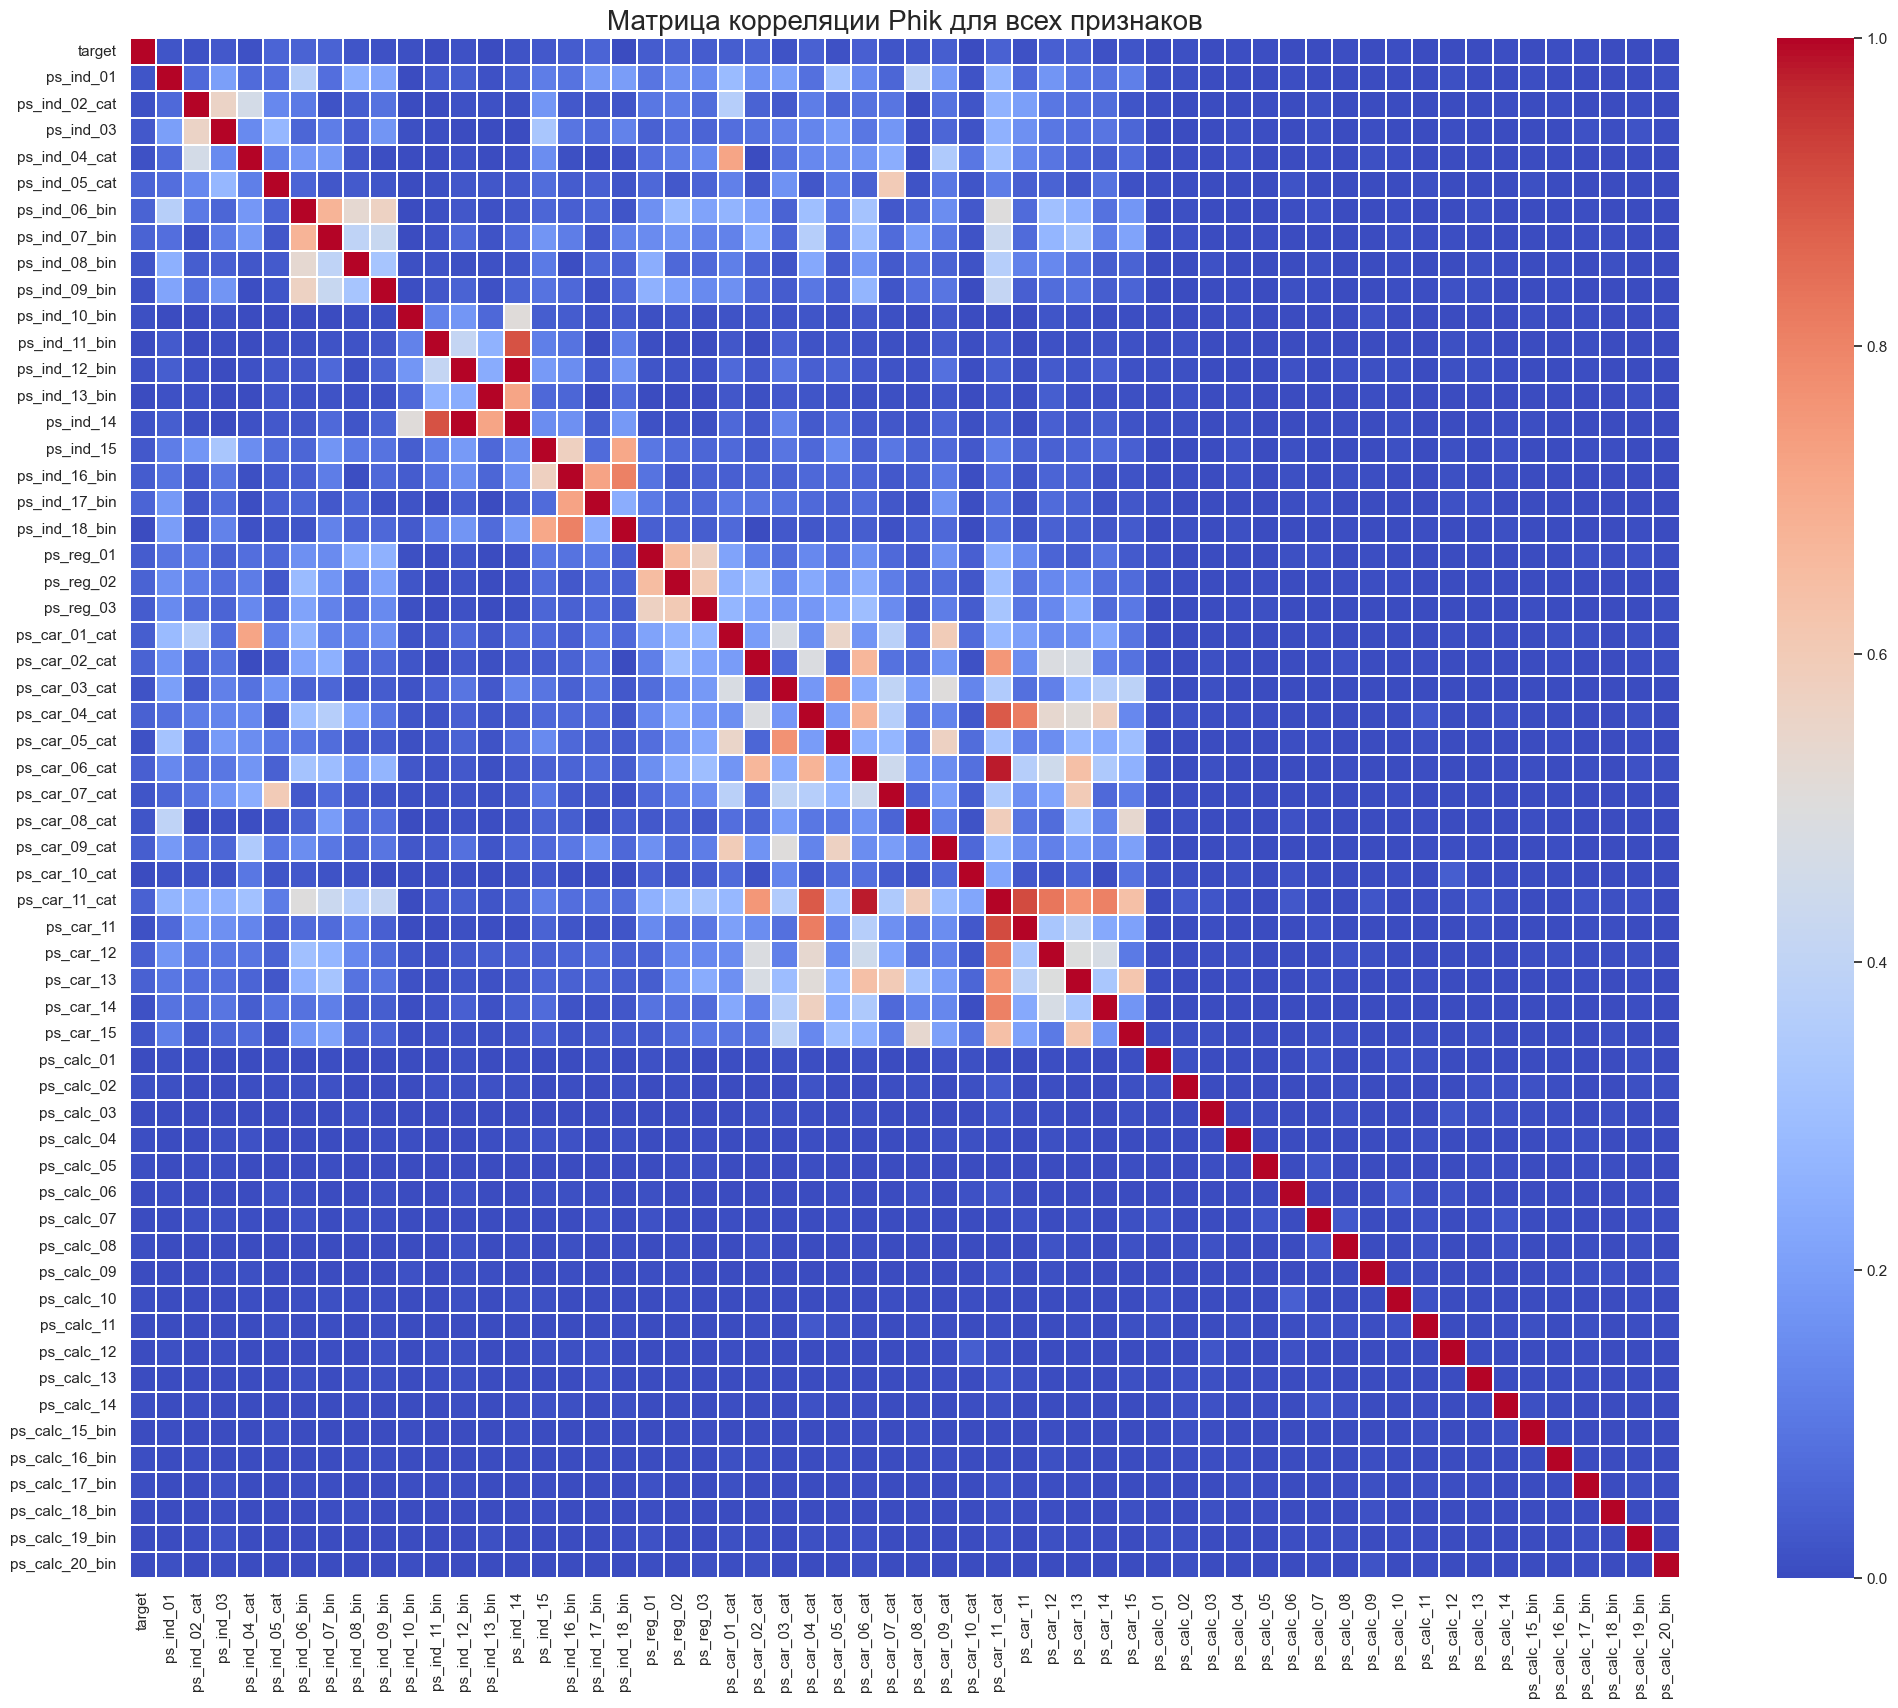

In [90]:
phik_matrix = train.sample(100000).phik_matrix(interval_cols=num_features)

plt.figure(figsize=(25, 20))

sns.heatmap(phik_matrix,
            annot=False,
            cmap='coolwarm',
            linewidths=0.1)

plt.title('Матрица корреляции Phik для всех признаков', fontsize=20)
plt.show()

In [91]:
threshold = 0.8

import numpy as np
upper = phik_matrix.where(np.triu(np.ones(phik_matrix.shape), k=1).astype(bool))

columns_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"Список на удаление: {columns_to_drop}")

Список на удаление: ['ps_ind_14', 'ps_ind_18_bin', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']


In [92]:
df = train.copy()
df.drop(columns_to_drop, axis=1, inplace=True)

In [93]:
num_features = [x for x in list(df.columns) if 'cat' not in x and 'bin' not in x and x not in ['target']]
cat_features = [x for x in list(df.columns) if 'cat' in x]
bin_features = [x for x in list(df.columns) if 'bin' in x]

# Baseline

In [94]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    C=0.2,
    random_state=42,
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

probs = model.predict_proba(X_val_scaled)[:, 1]
auc = roc_auc_score(y_val, probs)

print(f"Baseline ROC-AUC: {auc:.4f}")
print(f"Baseline Gini: {2 * auc - 1}")


Baseline ROC-AUC: 0.6235
Baseline Gini: 0.246973072103003


In [95]:
preds = model.predict(X_val_scaled)
accuracy_score(y_val, preds)

0.627437144561209

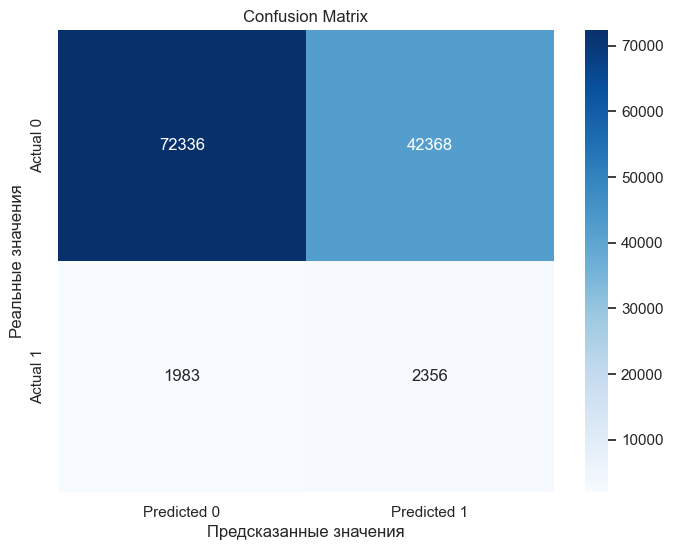

In [96]:
cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.ylabel('Реальные значения')
plt.xlabel('Предсказанные значения')
plt.title('Confusion Matrix')
plt.show()

C:\Users\serge\AppData\Local\Temp\ipykernel_1168\3297051181.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


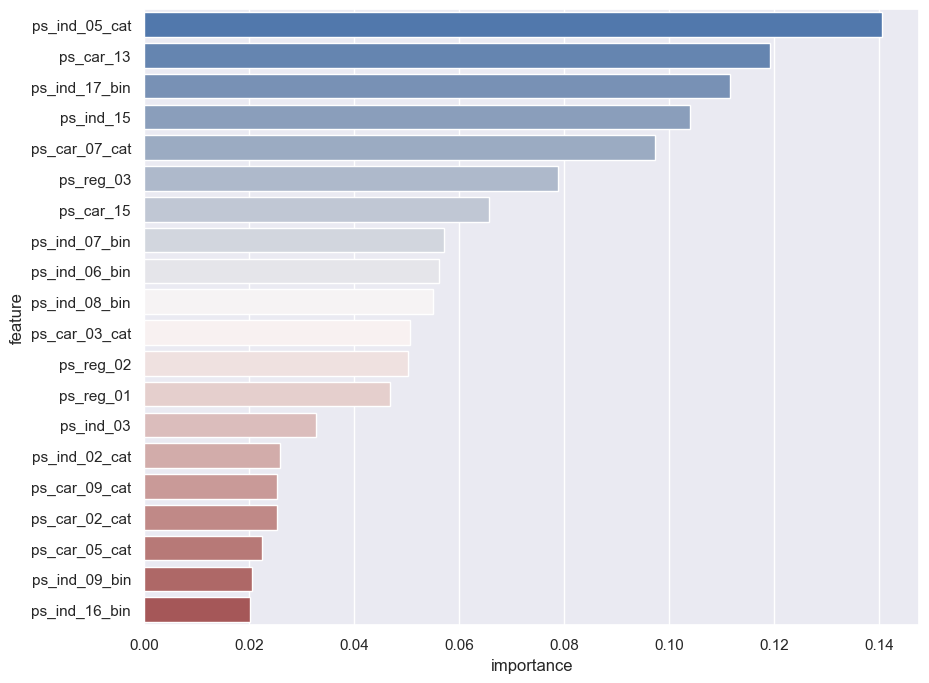

In [97]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.coef_[0]
})
feature_importance['importance'] = feature_importance['importance'].abs()
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance.head(20),
    palette='vlag'
)
plt.show()

# RandomForest

In [98]:
from sklearn.ensemble import RandomForestClassifier

rf_baseline = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,  
    random_state=42, 
    n_jobs=-1
)

rf_baseline.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [99]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.97      0.63      0.77    114704
           1       0.05      0.54      0.10      4339

    accuracy                           0.63    119043
   macro avg       0.51      0.59      0.43    119043
weighted avg       0.94      0.63      0.74    119043



In [100]:
preds = rf_baseline.predict(X_val)
probs = rf_baseline.predict_proba(X_val)[:, 1]
roc = roc_auc_score(y_val, probs)
print(f'Gini={2 * roc - 1}')


Gini=0.262756896989101


In [103]:
from catboost import CatBoostClassifier

cat_features = cat_features + bin_features

model_cb = CatBoostClassifier(
    iterations=500,          
    learning_rate=0.05,       
    depth=5,                 
    eval_metric='F1',         
    random_seed=42,
    verbose=100,
    auto_class_weights='Balanced'        
)

model_cb.fit(
    X_train, y_train,
    cat_features=cat_features, 
    eval_set=(X_val, y_val),   
    early_stopping_rounds=50,  
    use_best_model=True
)

y_pred = model_cb.predict(X_val)
f1_1 = f1_score(y_val, y_pred)
print(classification_report(y_val, y_pred))

0:	learn: 0.5644448	test: 0.5615930	best: 0.5615930 (0)	total: 681ms	remaining: 5m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5855498615
bestIteration = 1

Shrink model to first 2 iterations.
              precision    recall  f1-score   support

           0       0.97      0.57      0.72    114704
           1       0.05      0.59      0.09      4339

    accuracy                           0.57    119043
   macro avg       0.51      0.58      0.40    119043
weighted avg       0.94      0.57      0.69    119043



In [104]:
y_proba = model_cb.predict_proba(X_val)[:, 1]

roc = roc_auc_score(y_val, y_proba)
print(f'Gini={2*roc-1}')

Gini=0.21457581321733254
